In [1]:
import os
import sys
import glob
import scipy
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

font = {
    "size": 20
}

In [2]:
def load_mat(file_path):
    filename = os.path.basename(file_path).split(".")[0] # eg.B0005
    data = scipy.io.loadmat(file_path)
    # print(type(data)) # dict
    # print(data.keys()) # dict_keys(['__header__', '__version__', '__globals__', 'B0005'])
    # print(data["B0005"][0][0][0][0].shape) # (616,)，实验持续了616个循环
    # print(type(data["B0005"][0][0][0][0][0])) # 用scipy读取mat文件，读取到结构体返回 numpy.void 类型数据

    cols = data[filename][0][0][0][0]
    
    data = []
    
    for col in cols:
        _ = {}
        parameter = {}
        keys = list(col[3][0][0].dtype.fields.keys())
        if str(col[0][0]) != "impedance":
            for idx, key in enumerate(keys):
                parameter[key] = list(col[3][0][0][idx][0])

        operation_type = str(col[0][0])
        temperature = str(col[1][0][0])
        time = str(datetime(
            int(col[2][0][0]), int(col[2][0][1]), int(col[2][0][2]), int(col[2][0][3]), int(col[2][0][4]), int(col[2][0][5])
        ))
        _["type"], _["temperature"], _["time"], _["data"] = operation_type, temperature, time, parameter
        data.append(_)

    return data

def get_capacity(data):
    bcycle = len(data)
    capacity = []
    for i in range(0, bcycle):
        if data[i]["type"] == "discharge":
            capacity.append(data[i]["data"]["Capacity"][0])
    return capacity

In [3]:
battery_names = ["B0005", "B0006", "B0007", "B0018"]
data_root_path = "../../data/raw_data/nasa/"
data_path = [os.path.join(data_root_path, name + ".mat") for name in battery_names]

nasa_data = {}
for name, path in zip(battery_names, data_path):
    nasa_data[name] = load_mat(path)

# 获取容量数据
nasa_capacity = []
for key in list(nasa_data.keys()):
    nasa_capacity.append(np.array(get_capacity(nasa_data[key])))
nasa_capacity = np.array(nasa_capacity, dtype=object)

# 保存容量数据到 npy 文件
save_root_path = "../../data/processed_data/nasa/"
save_name = "nasa_capacity.npy"
save_path = os.path.join(save_root_path, save_name)
np.save(save_path, nasa_capacity)

In [4]:
# 读取容量数据
load_capacity = np.load(save_path, allow_pickle=True)

# 容量退化曲线可视化
battery_names = ["B0005", "B0006", "B0007", "B0018"]
for idx in range(len(battery_names)):
    plt.figure(figsize=(8, 6))
    plt.plot(load_capacity[idx])
    plt.xlabel("循环圈数", font)
    plt.ylabel("容量（Ah）", font)
    save_path = f"../../assets/thesis_figures/chapter_2/nasa_{battery_names[idx]}_capacity.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.clf()

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

Text(0, 0.5, '容量（Ah）')

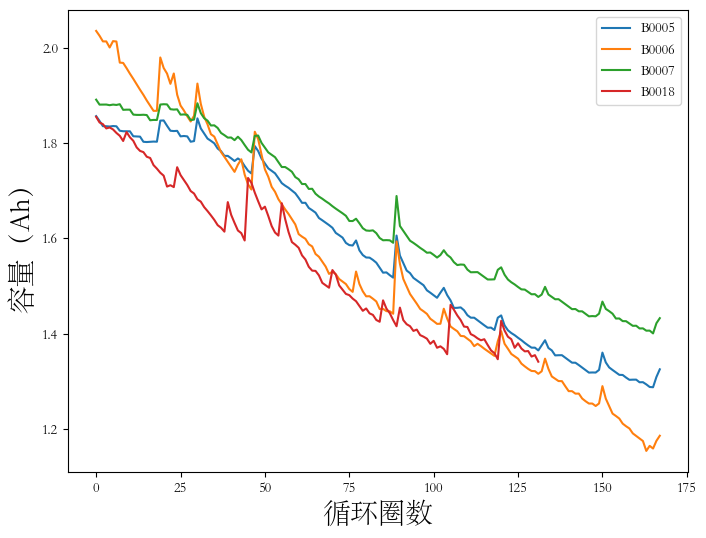

In [5]:
# 容量退化曲线可视化，在一张图中显示
save_path = "../../data/processed_data/nasa/nasa_capacity.npy"
load_capacity = np.load(save_path, allow_pickle=True)
battery_names = ["B0005", "B0006", "B0007", "B0018"]
plt.figure(figsize=(8, 6))
for i in range(len(battery_names)):
    plt.plot(load_capacity[i])
plt.legend(battery_names)    
plt.xlabel("循环圈数", font)
plt.ylabel("容量（Ah）", font)

In [28]:
# 电池数据统计
for index, cell in enumerate(list(nasa_data.keys())):
    charge_count, dischareg_count = 0, 0
    print(f"cell {cell}:")
    # init_capacity = battery_init_capacity[index]
    cell_data = nasa_data[cell]
    cell_data_len = len(cell_data)
    print(f"\tlength of cell data: {cell_data_len}")
    for i in range(cell_data_len - 1):
        if cell_data[i]["type"] == "charge":
            charge_count += 1
        if cell_data[i]["type"] == "discharge":
            dischareg_count += 1
    print(f"\tcharge count: {charge_count}, discharge count: {dischareg_count}")

cell B0005:
	length of cell data: 616
	charge count: 169, discharge count: 168
cell B0006:
	length of cell data: 616
	charge count: 169, discharge count: 168
cell B0007:
	length of cell data: 616
	charge count: 169, discharge count: 168
cell B0018:
	length of cell data: 319
	charge count: 134, discharge count: 131


In [5]:
# 新旧循环VIT对比
b0005_path = "../../data/raw_data/nasa/B0005.mat"
data = load_mat(b0005_path)
fresh_cell_time = [item / 60 for item in data[0]["data"]["Time"]]
fresh_cell_v = data[0]["data"]["Voltage_measured"] # voltage
fresh_cell_i = data[0]["data"]["Current_measured"] # current
fresh_cell_t = data[0]["data"]["Temperature_measured"] # temperature


old_cell_time = [item / 60 for item in data[167]["data"]["Time"]]
old_cell_v = data[167]["data"]["Voltage_measured"] # voltage
old_cell_i = data[167]["data"]["Current_measured"] # current
old_cell_t = data[167]["data"]["Temperature_measured"] # temperature

def compare_fresh_and_old(index_fresh, index_old, data_fresh, data_old, xlabel, ylabel, save_path):
    plt.figure(figsize=(8, 6))
    plt.plot(index_fresh, data_fresh)
    plt.plot(index_old, data_old)
    plt.xlabel(xlabel, font)
    plt.ylabel(ylabel, font)
    # plt.legend(["第1个循环", "第168个循环"])
    plt.legend(["第168个循环", "第1个循环"])
    plt.tight_layout()
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.clf()

compare_fresh_and_old(fresh_cell_time, old_cell_time, fresh_cell_v, old_cell_v, "时间（min）", "电压（V）", "../../assets/thesis_figures/chapter_2/fresh_old_cell_voltage.jpg")
compare_fresh_and_old(fresh_cell_time, old_cell_time, fresh_cell_i, old_cell_i, "时间（min）", "电流（A）", "../../assets/thesis_figures/chapter_2/fresh_old_cell_current.jpg")
compare_fresh_and_old(fresh_cell_time, old_cell_time, fresh_cell_t, old_cell_t, "时间（min）", "温度（℃）", "../../assets/thesis_figures/chapter_2/fresh_old_cell_temperature.jpg")

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [6]:
def save_diagram(index, data, xlabel, ylabel, save_path):
    plt.figure(figsize=(8, 6))
    plt.plot(index, data)
    plt.xlabel(xlabel, font)
    plt.ylabel(ylabel, font)
    plt.tight_layout()
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.clf()

In [7]:
# 充电参数变化曲线
print(nasa_data["B0005"][0]["data"].keys())
bcycle = len(nasa_data["B0005"])
for idx in range(bcycle):
    if nasa_data["B0005"][idx]["type"] == "charge":
        index = [time / 60 for time in nasa_data["B0005"][idx]["data"]["Time"]]
        save_diagram(index, nasa_data["B0005"][idx]["data"]["Voltage_measured"], "时间（min）", "电压（V）", "../../assets/thesis_figures/chapter_2/nasa_charge_voltage.jpg")
        save_diagram(index, nasa_data["B0005"][idx]["data"]["Current_measured"], "时间（min）", "电流（A）", "../../assets/thesis_figures/chapter_2/nasa_charge_current.jpg")
        save_diagram(index, nasa_data["B0005"][idx]["data"]["Temperature_measured"], "时间（min）", "温度（℃）", "../../assets/thesis_figures/chapter_2/nasa_charge_temperature.jpg")
        break

dict_keys(['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_charge', 'Voltage_charge', 'Time'])


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [8]:
# 放电参数变化曲线
bcycle = len(nasa_data["B0005"])
for idx in range(bcycle):
    if nasa_data["B0005"][idx]["type"] == "discharge":
        index = [time / 60 for time in nasa_data["B0005"][idx]["data"]["Time"]]
        save_diagram(index, nasa_data["B0005"][idx]["data"]["Voltage_measured"], "时间（min）", "电压（V）", "../../assets/thesis_figures/chapter_2/nasa_discharge_voltage.jpg")
        save_diagram(index, nasa_data["B0005"][idx]["data"]["Current_measured"], "时间（min）", "电流（A）", "../../assets/thesis_figures/chapter_2/nasa_discharge_current.jpg")
        save_diagram(index, nasa_data["B0005"][idx]["data"]["Temperature_measured"], "时间（min）", "温度（℃）", "../../assets/thesis_figures/chapter_2/nasa_discharge_temperature.jpg")
        break

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [9]:
# 电池容量退化曲线和失效阈值
data_path = "../../data/processed_data/nasa/nasa_capacity.npy"
save_root_path = "../../assets/thesis_figures/chapter_1"
plt.figure(figsize=(8, 6))
plt.xlabel("循环圈数")
plt.ylabel("容量（Ah）")
cap = np.load(data_path, allow_pickle=True)
for idx, i in enumerate(cap):
    cycle = list(range(len(i)))
    plt.scatter(cycle, i, s=5)
    plt.axhline(1.4, color="r")
    plt.xlabel("循环圈数", font)
    plt.ylabel("容量（Ah）", font)
    plt.legend([battery_names[idx] + "电池容量", "失效阈值"])
    save_path = os.path.join(save_root_path, f"nasa_{battery_names[idx]}_failure_threshold.jpg")
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.clf()
    break

<Figure size 800x600 with 0 Axes>

In [33]:
# def extract_charge(data):
#     charge_input = []
#     bcycle = len(data) # 616
#     print(bcycle)
#     # 最后一组数据的测量点过少，舍弃
#     for i in range(0, bcycle - 1):
#         if data[i]["type"] == "charge":
#             end = len(data[i]["data"]["Voltage_measured"])
#             le = end % 10

#             vTemp = np.array(data[i]["data"]["Voltage_measured"][0:end-le])
#             vTemp = vTemp.reshape(int(len(vTemp)/10), -1, order="F")
#             print("1: ", vTemp.shape)
#             print(vTemp)
#             vTemp = vTemp.mean(axis=0)
#             print("2: ", vTemp.shape)
#             print(vTemp)

#             iTemp = np.array(data[i]["data"]["Current_measured"][0:end-le])
#             iTemp = iTemp.reshape(int(len(iTemp)/10), -1, order="F")
#             iTemp = iTemp.mean(axis=0)

#             tTemp = np.array(data[i]["data"]["Temperature_measured"][0:end-le])
#             tTemp = tTemp.reshape(int(len(tTemp)/10), -1, order="F")
#             tTemp = tTemp.mean(axis=0)

#             charge_input.append(np.hstack((vTemp, iTemp, tTemp)))

#     charge_input = np.array(charge_input)
#     # print(charge_input.shape)
#     return charge_input

# def extract_discharge(data):
#     bcycle = len(data)
#     capacity = []
#     for i in range(0, bcycle):
#         if data[i]["type"] == "discharge":
#             capacity.append(data[i]["data"]["Capacity"][0])
#     return capacity

# def max_min_norm(charge_input, init, cap):
#     print(charge_input.shape)
    
#     r = np.max(charge_input, axis=0) - np.min(charge_input, axis=0)
#     print("here")
#     print(np.max(charge_input, axis=0))
#     print(np.min(charge_input, axis=0))
#     print(r)
#     print("here")
#     X = (charge_input - np.min(charge_input, axis=0)) / r

#     comp = len(charge_input) - len(cap)
#     y = [init for _ in range(comp)] + cap
#     ym = np.min(y)
#     yr = np.max(y) - np.min(y)
#     y = (y - ym) / yr
#     return X, y, ym, yr

# def min_max_scaler(data):
#     min, max = np.min(data), np.max(data)
#     r = max - min
#     data = (data - min) / r
#     return  data, min, r

# def de_min_max_scaler(data, min, r):
#     return data * r + min